# Poisson's equation

Now extend your solver to solve for Poisson's equation.
* Consider a 64 x 64 grids in a domain ($-1<x<1$ and $-1<y<1$)
* Assume $\rho(r)= \exp(-10r)$
* Assume $u$ is zero on the four boundaries.
* Solver for the potential $u$.
* What is the corresponding electrical (or gravitational) field? (Hints: use `numpy.gradient()`)

In [6]:
import numpy as np
from scipy.sparse import dia_array  # if dia_array is not able, use dia_matrix
from scipy.sparse import dia_matrix
from scipy.sparse import csc_matrix
import scipy.sparse.linalg as splinalg
from numba import jit, njit, prange
import matplotlib.pyplot as plt

In [7]:
# Copy your Laplace's Equation solver from demo1 here
def generate_1_4_1_dia(usize=4):
    ex = np.ones(usize)
    data = np.array([-ex, 4 * ex, -ex])
    offsets = np.array([-1, 0, 1])
    A = dia_array((data, offsets), shape=(usize, usize)).toarray()
    return A

def generate_the_laplace_matrix_with_size(N=4):
    """
    assume sqrt(N) is an integer.

    """
    nsq = N*N
    A   = np.zeros((nsq,nsq))
    u   = generate_1_4_1_dia(N)

    d_matrix = generate_1_4_1_dia(N)
    o_matrix = -np.identity(N)
    z_matrix = np.zeros((N,N))

    init_matrix_kernel(N,A,u,d_matrix,o_matrix,z_matrix)
    return A

@njit(parallel=True)
def init_matrix_kernel(N,A,u,d_matrix,o_matrix, z_matrix):
    for i in prange(N):
        for j in prange(N):
            if u[i,j] == 4:
                # the elemen is another 1_4_1 matrix
                suba = d_matrix
            elif u[i,j] == -1:
                suba = o_matrix
            else:
                suba = z_matrix
            
            for i2 in range(N):
                for j2 in range(N):
                    ii = i2 + i*N
                    jj = j2 + j*N
                    A[ii,jj] = suba[i2,j2]
    return A

#def generate_the_rhs_vector_with_size(N=4):
#    b = np.zeros(N*N)
#    b[-N:] = 1
#    return b

def convert_solution(x):
    usize = np.sqrt(len(x))
    u = x.reshape(int(usize),int(usize)).transpose()
    return u


The right hand side vector need to be updated when there is a density field $\rho$.
First, we write a function `generate_rho()` to generate the $N \times N$ density field.

In [8]:
def generate_rho(N, xmin=-1, xmax=1, ymin=-1,ymax=1):
    # TODO:
    dx = (xmax-xmin)/N
    dy = (ymax-ymin)/N
    x = np.linspace(xmin+dx,xmax-dx,N)
    y = np.linspace(ymin+dy,ymax-dy,N)
    xx, yy = np.meshgrid(x,y,indexing="ij")
    radius = np.sqrt(xx**2 + yy**2)
    rho    = np.exp(-10*radius)
    return rho

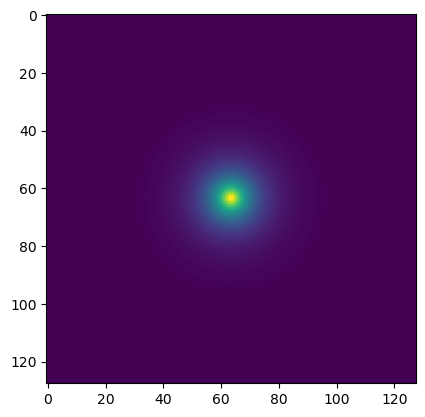

In [9]:
# Visualize the density field
rho = generate_rho(N=128)
plt.imshow(rho)

Once we have the density filed, we need to modify the `generate_the_rhs_vector_with_size()` to include the density field.

In [11]:
def generate_the_rhs_vector_with_size(N=4, rho=None, dx=1):
    
    #TODO:
    if rho is None:
        b = np.zeros(N*N)
        b[-N:] += 1
    else:
        b = rho.flatten() 
        b = -b*dx**2
    return b

We could solve the system by the same way in `solve_laplace()`.

In [15]:
def solve_laplace(N=16):
    A = generate_the_laplace_matrix_with_size(N=N)

    rho = generate_rho(N=N)
    b = generate_the_rhs_vector_with_size(N=N, rho=rho, dx=2/(N-1))
    #x = linalg.solve(A,b) # use scipy
    #x = lu_solve(A,b)      # use our solver
    x = splinalg.spsolve(A,b) # use scipy sparse solver
    u = convert_solution(x)
    return u

In [18]:
u = solve_laplace(N=128)

/tmp/ipykernel_6918/803127758.py:8: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  x = splinalg.spsolve(A,b) # use scipy sparse solver


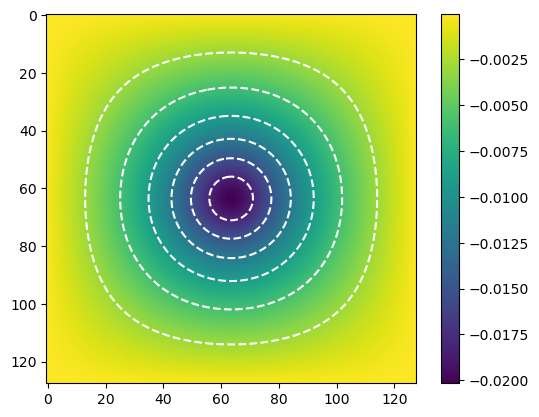

In [19]:
# Visualize the solution
plt.imshow(u)
plt.colorbar()
plt.contour(u,colors="w")

Calculate the gravitational field

In [20]:
phi =np.gradient(u)

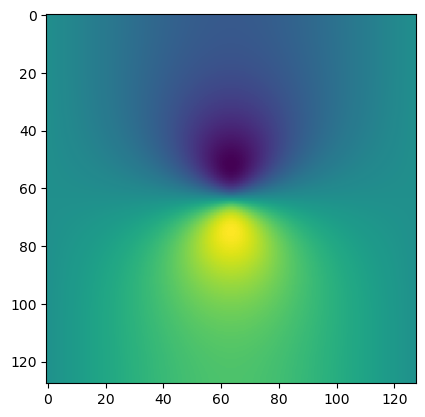

In [21]:
plt.imshow(phi[0]) # x derivative

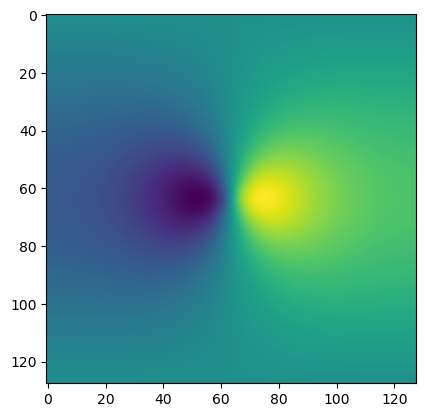

In [22]:
plt.imshow(phi[1]) # y derivative